In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from pandas import Series
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

from statsmodels.tsa.stattools import adfuller
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# PATH WHERE THE FILES ARE SAVED
# path = r'/dbfs/FileStore/tables/'
path = './'

# IMPORT OF DATABASE
ddf = pd.read_excel(path + r'/2_cleaned_data/clean_ddf.xlsx')

# IMPORT OF VARIABLES FROM PRE-PROCESSING NOTEBOOK
preprocess1 = (path + r'/3_variables/var1_pre_processing.sav')
num_nan, inv_values = pickle.load(open(preprocess1, 'rb'))

preprocess2 = (path + r'/3_variables/var2_pre_processing.sav')
outlier_df = pickle.load(open(preprocess2, 'rb'))

# IMPORT OF DATA FROM FRAMEWORK CONFIGURATION
frameworkconfig1 = (path + r'/3_variables/var1_framework_config.sav')
ddf_config_var = pickle.load(open(frameworkconfig1, 'rb'))

# frameworkconfig2 = (path + r'/3_variables/var2_framework_config.sav')
# ddf_config_kpi = pickle.load(open(frameworkconfig2, 'rb'))

frameworkconfig3 = (path + r'/3_variables/var3_framework_config.sav')
ddf_config_par = pickle.load(open(frameworkconfig3, 'rb'))

In [4]:
# PRIMARY KEY
primary_key = ddf_config_var.loc[np.where(ddf_config_var["VariableUsage"]=='PRIMARY')[0][0],'VariableName']

# FILTER BY COLUMN
filter_by = ddf_config_par.loc[0,'Value']

# FILTER BY VALUE
filter_value = ddf_config_par.loc[1,'Value']

if str(filter_by)!='nan':
    # PRIMARY KEY LIST WITH FILTER 
    pk_list = ddf[primary_key][ddf[filter_by]==filter_value].unique()
else:
    # PRIMARY KEY LIST 
    pk_list = ddf[primary_key].unique()
    
# DATETIME VARIABLE
date_column = ddf_config_var.loc[np.where(ddf_config_var["VariableType"]=='DATETIME')[0][0],'VariableName']

# TARGET VARIABLE
target = ddf_config_var.loc[np.where(ddf_config_var["VariableUsage"]=='TARGET')[0][0],'VariableName']

# EXOGENOUS VARIABLE
exogenous = []
for i in ddf_config_var.loc[np.where(ddf_config_var["VariableUsage"]=='EXOGENOUS')[0],'VariableName']:
    exogenous.append(i)

In [5]:
time_variables = list(ddf_config_var.loc[np.where(ddf_config_var["VariableType"]=='DATETIME')[0],'VariableName'])
numeric_variables = list(ddf_config_var.loc[np.where(ddf_config_var["VariableType"]=='NUMERIC')[0],'VariableName']) 
categorical_variables = list(ddf_config_var.loc[np.where(ddf_config_var["VariableType"]=='CATEGORICAL')[0],'VariableName'])

# VARIABLES FORMAT
ddf[time_variables] = ddf[time_variables].astype('object')
for col in categorical_variables:
    ddf[col] = ddf[col].astype('category')
ddf[numeric_variables] = ddf[numeric_variables].astype('float')

In [6]:
# MEAN, STANDARD DEVIATION, MINIMUM, P25, P50, P75 AND MAXIMUM
data_stats_post = pd.DataFrame.describe(ddf).transpose()
data_stats_post

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2220.0,1109.500000,641.003120,0.00,554.75,1109.5,1664.25,2219.00
Volume (Un),2220.0,37786.243386,109842.924347,106.26,4910.73,11688.6,25267.11,1140685.92
Revenue (R$),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Preco,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# MEAN, STANDARD DEVIATION, MINIMUM, MAXIMUM AND COEFFICIENT OF VARIATION DISAGGREGATED BY PRIMARY KEY
data_stats_by = ddf.groupby(primary_key).agg(['mean','std','min','max',lambda x: round(x.std()/abs(x.mean())*100,2) if abs(x.mean())!=0 else float('Inf')])
data_stats_by

Unnamed: 0                                   Volume (Un)  \
                       mean         std min   max <lambda>           mean   
DFU                                                                         
Retail10064446  1127.810811  648.469173  59  2203    57.50    3795.000000   
Retail10064511  1088.702703  649.050797   8  2168    59.62   62248.260556   
Retail10064512  1095.351351  651.185595  11  2172    59.45   29044.689143   
Retail10064569  1126.189189  650.267758  53  2204    57.74    3904.385294   
Retail10065164  1128.675676  651.759544  46  2214    57.75    4219.477778   
Retail10065299  1127.513514  646.855497  50  2208    57.37    3841.118286   
Retail10065397  1089.756757  650.481762   0  2176    59.69   49236.892222   
Retail10065398  1096.810811  650.314746  12  2180    59.29   27063.128889   
Retail10065433  1084.405405  648.835729   2  2160    59.83  315909.640588   
Retail10065434  1083.702703  649.433080   1  2166    59.93  758576.261143   
Retail10065435  1085.702703  649.435390   3  2167    59.82  224230.807778   
Retail10065436  1089.432432  649.850390   6  2170    59.65   41852.841250   
Retail10065437  1092.486486  649.567318   7  2174    59.46   37883.517222   
Retail10065446  1109.594595  650.664765  51  2201    58.64   11265.773750   
Retail10065528  1111.189189  647.496111  35  2184    58.27   11313.292571   
Retail10065529  1086.567568  649.746640   4  2169    59.80  102782.478857   
Retail10065536  1108.324324  648.135148  25  2197    58.48   13410.265000   
Retail10065591  1104.216216  648.530224  33  2188    58.73   13963.228125   
Retail10065592  1126.135135  648.347779  57  2161    57.57    3959.003529   
Retail10065594  1127.675676  650.633540  54  2211    57.70    4545.521081   
Retail10066359  1130.864865  649.029368  49  2218    57.39    3853.531892   
Retail10067131  1125.810811  646.745736  48  2206    57.45    3698.161515   
Retail10072448  1105.918919  650.161962  18  2183    58.79   14741.607222   
Retail10072451  1096.648649  649.563794  15  2181    59.23   24434.888824   
Retail10072472  1097.540541  647.759369  20  2182    59.02   24429.535429   
Retail10072504  1109.783784  650.016672  31  2198    58.57   11332.316471   
Retail10072508  1113.432432  650.836579  27  2187    58.45   10384.947222   
Retail10072527  1109.945946  650.572481  32  2192    58.61   11532.484118   
Retail10072591  1095.648649  649.416115   9  2173    59.27   27798.747059   
Retail10073176  1102.972973  652.485227  26  2190    59.16   13723.563333   
Retail10073222  1125.243243  651.906154  44  2216    57.93    4364.994118   
Retail10073265  1113.216216  649.866744  30  2199    58.38   10716.658333   
Retail10073299  1127.702703  650.206244  42  2207    57.66    4202.470556   
Retail10073332  1107.945946  650.343027  40  2195    58.70   11888.628125   
Retail10073355  1121.540541  651.675558  43  2213    58.11    4176.458710   
Retail10073362  1108.351351  651.079668  22  2193    58.74   12960.828571   
Retail10073373  1129.351351  648.654343  52  2205    57.44    3855.157778   
Retail10073376  1127.189189  648.560707  55  2202    57.54    4043.518286   
Retail10073378  1106.108108  648.893065  23  2189    58.66   14522.902778   
Retail10073871  1106.783784  652.199490  38  2162    58.93   10489.199286   
Retail10074338  1124.108108  651.852905  45  2212    57.99    3995.935906   
Retail10075005  1124.486486  644.804993  56  2210    57.34    3705.817500   
Retail10076094  1091.405405  649.218054   5  2178    59.48   42045.600943   
Retail10076095  1093.027027  649.919759  14  2177    59.46   34684.964743   
Retail10076097  1107.000000  647.272182  24  2194    58.47   14579.344714   
Retail10076103  1111.864865  651.376498  29  2200    58.58    9303.532125   
Retail10076466  1128.918919  650.403523  39  2219    57.61    4279.118919   
Retail10076478  1129.324324  650.353667  36  2217    57.59    4291.016757   
Retail10076697  1098.162162  648.554183  16  2179    59.06   24089.648000   
Retail1007669

In [8]:
# TABLE WITH PERCENTAGE OF MISSING VALUES, INVALID VALUES AND OUTLIERS
# PERCENTAGE OF MISSING VALUES
data_cleaning = pd.DataFrame(round(num_nan/len(ddf)*100,2))
data_cleaning.columns =['%nan']

# PERCENTAGE OF INVALID VALUES
inv_values['invalid_values'] = inv_values['invalid_values'].astype('float')

for i in numeric_variables:
    j = i
    j = inv_values['invalid_values'][inv_values['numeric_variable']==j]
    j = j.values
    data_cleaning.loc[i,'invalid_values'] = round(j[0]/len(ddf)*100,2)

inv_perc = pd.DataFrame(data_cleaning['invalid_values'])

# PERCENTAGE OF OUTLIERS
for i in numeric_variables:
    j = 'outliers_' + i[:3]
    j = outlier_df['outlier_number'][outlier_df['outlier_name']==j]
    j = j.values
    data_cleaning.loc[i,'outliers'] = round(j[0]/len(ddf)*100,2)

outlier_perc = pd.DataFrame(data_cleaning['outliers'])
data_cleaning

,%nan,invalid_values,outliers
Date,0.00,NaN,NaN
Product,0.00,NaN,NaN
Volume (Un),6.67,0.0,0.0
Revenue (R$),100.00,0.0,0.0
Preco,100.00,0.0,0.0
Unidade de Negocio,0.00,NaN,NaN
DFU,0.00,NaN,NaN


In [9]:
pk_value = ddf[primary_key].unique()[0]

In [10]:
# TIME SERIES OF TARGET OF PRIMARY KEY VALUE
target_p1 = []
date_p1 = []

# for pro in products:
target_p1.append(ddf[target][ddf[primary_key]==pk_value])
date_p1.append(ddf[time_variables][ddf[primary_key]==pk_value])

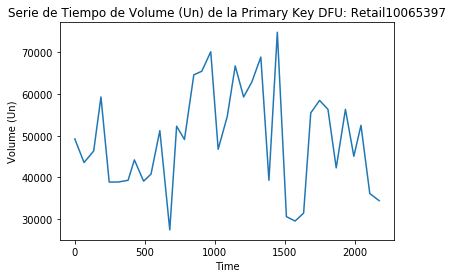

In [11]:
# PLOT OF TIME SERIES
# for i in pk_list:    
plt.plot(ddf[target][ddf[primary_key]==pk_value])
plt.title('Serie de Tiempo de ' + target + ' de la Primary Key ' + primary_key + ': ' + str(pk_value))
plt.ylabel(target)
plt.xlabel('Time')
display()

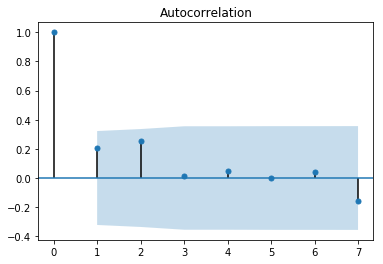

In [12]:
# PLOT OF AUTOCORRELATION FUNCTION
plot_acf(ddf[target][ddf[primary_key]==pk_value], lags= 7, alpha=0.05)
# print(acf(ddf[target][ddf[primary_key]==pk_value]))
display()

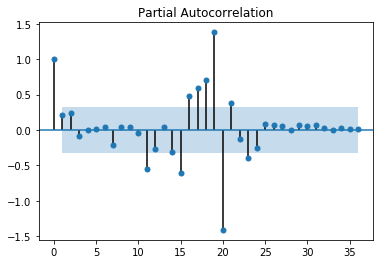

In [13]:
# PLOT OF PARTIAL AUTOCORRELATION FUNCTION
# plot_pacf(ddf[target][ddf[primary_key]==pk_value],method='ywu')
plot_pacf(ddf[target][ddf[primary_key]==pk_value],method='ols')
# print(pacf(ddf[target][ddf[primary_key]==pk_value]))
display()

In [14]:
# AUGMENTED DICKEY-FULLER TEST (STATIONARITY TEST: IF THE NULL HYPOTHESIS IS REJECTED, THEN THE SERIES IS STATIONARY)
ADF = adfuller(ddf[target][ddf[primary_key]==pk_value].values)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items(): 
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.577946
p-value: 0.000142
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


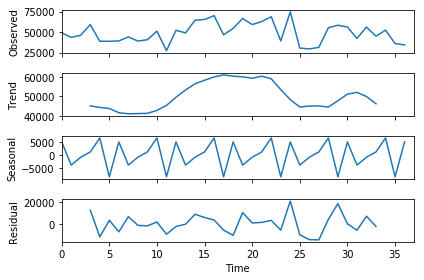

In [15]:
# BREUSCH-PAGAN TEST (SEASONALITY TEST)
seasonal_test = seasonal_decompose(tuple(ddf[ddf[primary_key]==pk_value][target]), model='Additive', freq=6)
seasonal_test.seasonal
seasonal_test.plot()
display()